# Ripple NRTidal verification notebook

In [297]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from ripple.waveforms import IMRPhenomD
import matplotlib.pyplot as plt
from ripple import ms_to_Mc_eta
from ripple.constants import MSUN, gt
from jax import grad, vmap
from functools import partial
# import importlib
# import tqdm

%load_ext autoreload
%autoreload 2
from ripple.waveforms import X_NRTidalv2

# To get plot style
import requests
script_url = "https://raw.githubusercontent.com/ThibeauWouters/cheat_sheets/main/myploystyle.py"
exec(requests.get(script_url).text)

jax.config.update("jax_enable_x64", True) # improve precision for comparing waveforms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will compare waveforms with the following intrinsic parameters, which are close to the extremes on which the LAL implementation has been reviewed:

Problematic (NaN) values: 
- m = 2.212299314305308
- lambda = 1670.7311827730764

In [298]:
m1 = 3 # masses # 2.212299314305308
m2 = m1
# m2 = 0.75

chi1 = 0.0 # spins
chi2 = 0.0

lambda1 = 5000 # tidal deformabilities # 1670.7311827730764
lambda2 = lambda1

distance = 440.

Get the frequency grid:

In [299]:
# Frequency grid
T = 16
f_l = 20.0
f_l = 16.0
f_sampling = 2 * 4096
# f_u = f_sampling // 2
f_u = 500
f_ref = f_l

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
# df = 0.01
fs = freqs[(freqs > f_l) & (freqs < f_u)]

## Ripple

In [300]:
m1_msun = m1
m2_msun = m2
chi1 = chi1
chi2 = chi2
tc = 0
phic = 0
dist_mpc = distance
inclination = 0.0
polarization_angle = 0.0

Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))

theta_ripple = jnp.array([Mc, eta, chi1, chi2, lambda1, lambda2, dist_mpc, tc, phic, inclination])
fs_ripple = jnp.arange(f_l, f_u, df)[1:]

# And finally lets generate the waveform!
hp_ripple, hc_ripple = X_NRTidalv2.gen_NRTidalv2_hphc(fs_ripple, theta_ripple, f_ref)

[2.61165169e+00 2.50000000e-01 0.00000000e+00 0.00000000e+00
 4.40000000e+02 0.00000000e+00 0.00000000e+00]
Kappa
937.5
[ 1.24333990e-23+8.93045449e-24j  9.28712737e-24+1.20815435e-23j
  9.63808072e-24+1.17141465e-23j ... -2.20988728e-25-5.79495485e-26j
 -2.20807142e-25-5.84874640e-26j -2.20624308e-25-5.90246565e-26j]
BBH results
[1.53082471e-23 1.52385835e-23 1.51695032e-23 ... 2.28460430e-25
 2.28421929e-25 2.28383440e-25]
[-0.62287836+2.22044605e-16j -0.91543191+0.00000000e+00j
 -0.88232297+0.00000000e+00j ...  2.88513831+0.00000000e+00j
  2.88265876+0.00000000e+00j  2.88018004+0.00000000e+00j]
Amp0
6.082317878558626e-27
Tidal amplitude
[-6.50042679e-29 -6.55661243e-29 -6.61306841e-29 ... -1.84287848e-25
 -1.84326469e-25 -1.84365090e-25]
Psi tidal
[ -0.1831459   -0.18434838  -0.18555408 ... -80.98401613 -81.00436362
 -81.02471361]
Psi SS
[0. 0. 0. ... 0. 0. 0.]


In [301]:
test_low = X_NRTidalv2._compute_quadparam_octparam(0)
test_high = X_NRTidalv2._compute_quadparam_octparam(350)

In [302]:
print(test_low)
print(test_high)

(Array(0., dtype=float64, weak_type=True), Array(0.00313591, dtype=float64, weak_type=True))
(Array(4.29658985, dtype=float64, weak_type=True), Array(9.49831745, dtype=float64, weak_type=True))


## LAL

Check the LAL code (and also how to compute the mismatch between your waveform and LAL) in [this tutorial](https://github.com/tedwards2412/ripple/blob/main/test/check_waveform_match.py).

In [303]:
import lalsimulation as lalsim
import lal

from ripple import get_eff_pads

In [304]:
laldict = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertTidalLambda1(laldict, lambda1)
lalsim.SimInspiralWaveformParamsInsertTidalLambda2(laldict, lambda2)

0

In [305]:
IMRphenom = "IMRPhenomD_NRTidalv2"
approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

f_ASD, ASD = np.loadtxt("../test/O3Livingston.txt", unpack=True)

theta = np.array([m1, m2, chi1, chi2, lambda1, lambda2, dist_mpc, tc, phic, inclination])

m1_kg = theta[0] * lal.MSUN_SI
m2_kg = theta[1] * lal.MSUN_SI
distance = dist_mpc * 1e6 * lal.PC_SI

hp, _ = lalsim.SimInspiralChooseFDWaveform(
    m1_kg,
    m2_kg,
    0.0,
    0.0,
    chi1,
    0.0,
    0.0,
    chi2,
    distance,
    inclination,
    phic,
    0,
    0,
    0,
    df,
    f_l,
    f_u,
    f_ref,
    laldict,
    approximant,
)
freqs_lal = np.arange(len(hp.data.data)) * df

# Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))

# theta_ripple = np.array(
#     [Mc, eta, theta[2], theta[3], dist_mpc, tc, phic, inclination]
# )
# hp_ripple = waveform(theta_ripple)

mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
hp_lalsuite = hp.data.data[mask_lal]

Quick test:

## Comparison

In [306]:
# One frequency variable, just f
f = freqs_lal[mask_lal]

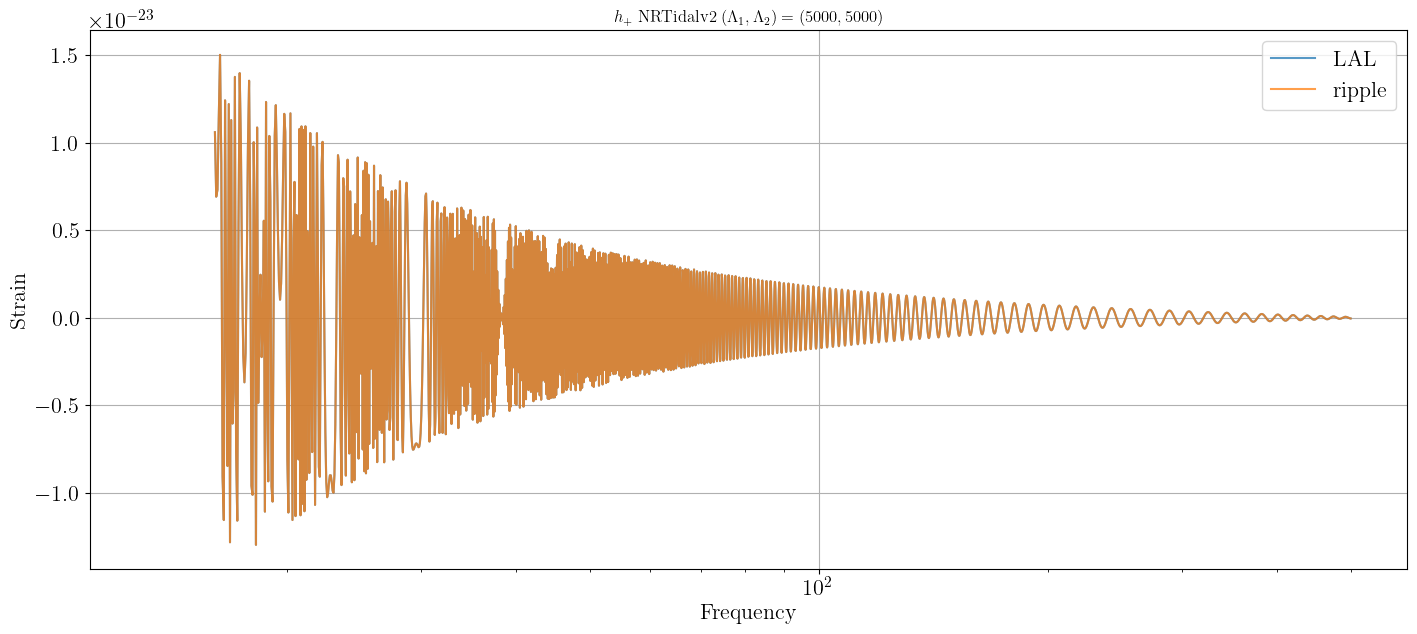

In [307]:
a = 0.75
plt.subplots(1, 1, figsize=(17, 7))
# plt.subplot(1, 2, 1)

plt.plot(f, hp_lalsuite.real, "-", label = "LAL", alpha = a)
plt.plot(f, hp_ripple.real, "-", label = "ripple", alpha = a)
plt.title(f"h+, NRTidalv2 lambda1, lambda2 = {lambda1, lambda2}")
plt.title(r"$h_+$ NRTidalv2 ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(lambda1, lambda2))
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.legend()
plt.show()

In [308]:
# plt.subplots(1, 1, figsize=(17, 7))
# diffs = abs(hp_lalsuite.real - hp_ripple.real) 
# plt.plot(f, diffs, "-", label = "Differences", color="black")
# plt.title(f"h+, NRTidalv2 lambda1, lambda2 = {lambda1, lambda2}")
# plt.title(r"$h_+$ NRTidalv2 ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(lambda1, lambda2))
# plt.xlabel("Frequency")
# plt.ylabel("Strain")
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(f_l - 5)
# plt.legend()
# plt.show()

My kappa: 937.5
Frequency merger:  506.57584266787893
Frequency merger LAL 506.5758506799589
Lal kappa: 937.5


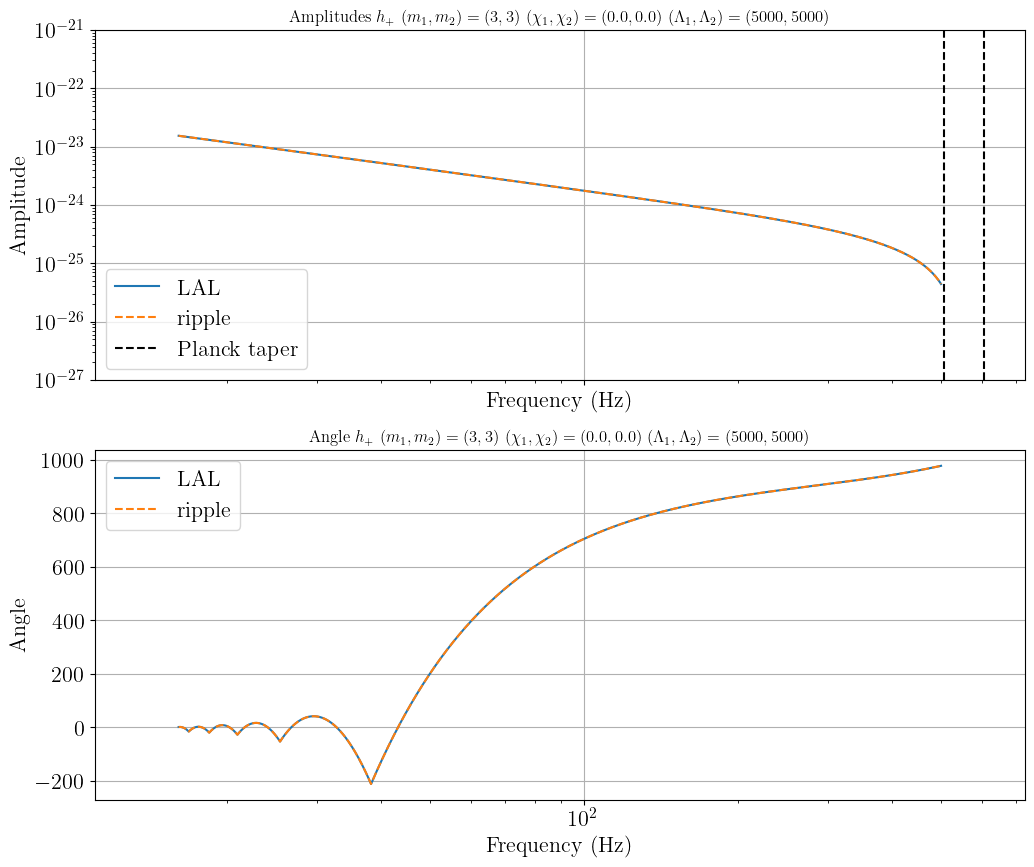

In [309]:
## Get the merger frequency to check the Planck taper window

l1, l2 = lambda1, lambda2
merger_params = jnp.array([m1, m2, chi1, chi2, l1, l2])
print(f"My kappa: {X_NRTidalv2.get_kappa(merger_params)}")

f_merger = X_NRTidalv2._get_merger_frequency(merger_params)
f_merger = float(f_merger)

# print("Merger params (m1, m2, chi1, chi2, lambda1, lambda2): ", merger_params)
print("Frequency merger: ", f_merger)

## Get amplitude and angle for comparison

A_lalsuite = jnp.abs(hp_lalsuite)
angle_lalsuite = np.unwrap(np.angle(hp_lalsuite))
phase_lalsuite = hp_lalsuite / A_lalsuite

A_ripple = jnp.abs(hp_ripple)
angle_ripple = np.unwrap(np.angle(hp_ripple))
phase_ripple = hp_ripple / A_ripple

# Choose whether we plot the angle or the phase
plot_angle = True

plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
plt.plot(freqs_lal[mask_lal], A_lalsuite, "-", label = "LAL")
plt.plot(fs_ripple, A_ripple, "--", label = "ripple")

# Plot where the Planck taper has to take place
plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper')
plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black')


lal_kappa = lalsim.SimNRTunedTidesComputeKappa2T(m1, m2, l1, l2)
lal_f_merger = lalsim.SimNRTunedTidesMergerFrequency((m1 + m2), lal_kappa, m1/m2)
print(f"Frequency merger LAL {lal_f_merger}")

# Kappas
print(f"Lal kappa: {lal_kappa}")

plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5)
plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)
if plot_angle:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label = "LAL")
    plt.plot(fs_ripple, angle_ripple, "--", label = "ripple")
    name = "Angle"
else:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label = "LAL")
    plt.plot(fs_ripple, phase_ripple, "--", label = "ripple")
    name = "Phase"
plt.legend()
plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.show()

In [310]:
# df_ripple = fs_ripple[1] - fs_ripple[0]
# df_lal = freqs_lal[1] - freqs_lal[0]

# print(df_ripple)
# print(df_lal)

# print(fs_ripple[-1])
# print(freqs_lal[mask_lal][-1])
# print(abs(freqs_lal[mask_lal][-1] - fs_ripple[-1]))

In [311]:
# correct_freqs = True # correct frequency grid by interpolation
# if correct_freqs:
#     A_lalsuite = jnp.interp(f, freqs_lal[mask_lal], A_lalsuite)
#     angle_lalsuite = jnp.interp(f, freqs_lal[mask_lal], angle_lalsuite)

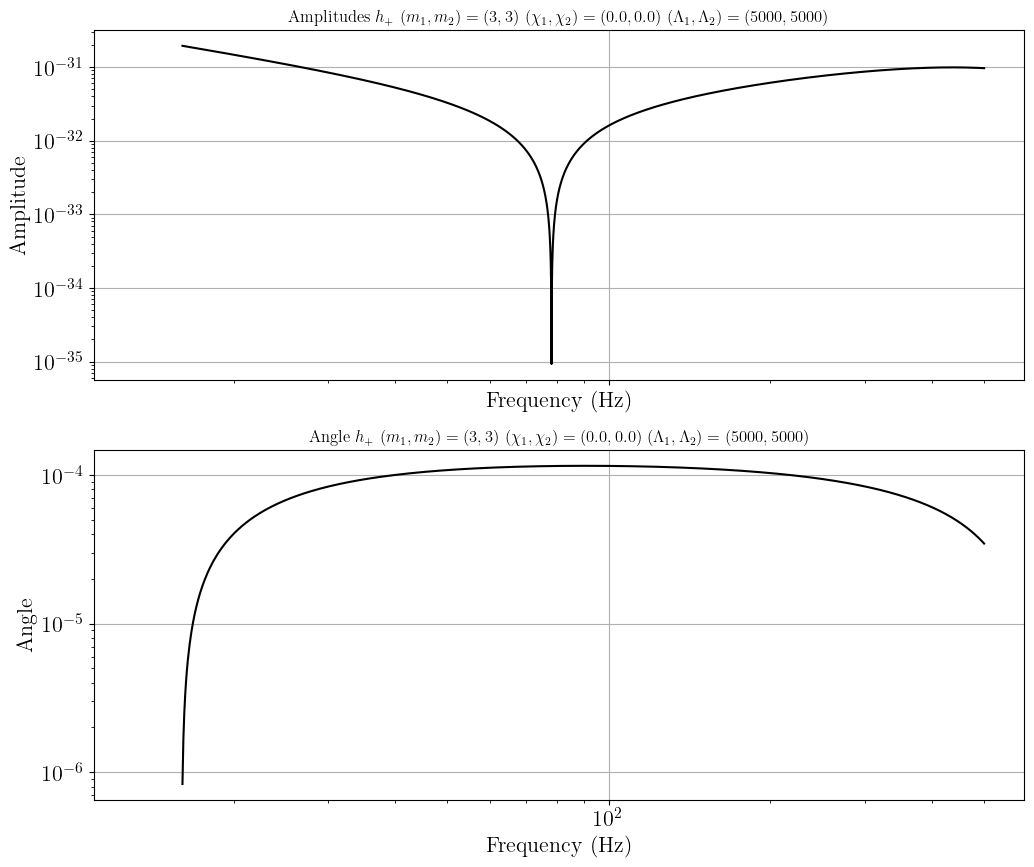

In [312]:
plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
diffs_amplitude = abs(A_lalsuite - A_ripple)
plt.plot(f, diffs_amplitude, "-", color = 'black')

# Plot where the Planck taper has to take place
# plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper')
# plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black')

plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5)
# plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)

plt.plot(f, abs(angle_lalsuite - angle_ripple), "-", color = 'black')
name = "Angle"
# plt.legend()
plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.yscale('log')
plt.show()

**Discussion:** Same remarks as above. For the angle, the spin-spin contributions could solve the increasing error in the second plot. For the amplitude: I am a bit surprised that the error in amplitude seems to be increasing with increasing frequency and I am not sure what is causing this. This will not be fixed by the Planck taper. Is there another bug in the implementation? 

# Debugging

### Kappa and merger frequency?

In [313]:
lal_kappa = lalsim.SimNRTunedTidesComputeKappa2T(m1 * MSUN, m2* MSUN, lambda1, lambda2)
print(lal_kappa)
lal_f_merger = lalsim.SimNRTunedTidesMergerFrequency((m1 + m2), lal_kappa, m1/m2)
print(lal_f_merger)
lal_f_merger = lalsim.SimNRTunedTidesMergerFrequency((m1 + m2), 5000, m1/m2)
print(lal_f_merger)

937.5
506.5758506799589
403.5843715677725


### TODO Tidal corrections phase

In [316]:
psi_SS = X_NRTidalv2.get_spin_phase_correction(fs_ripple, jnp.array([m1, m2, chi1, chi2, lambda1, lambda2]))


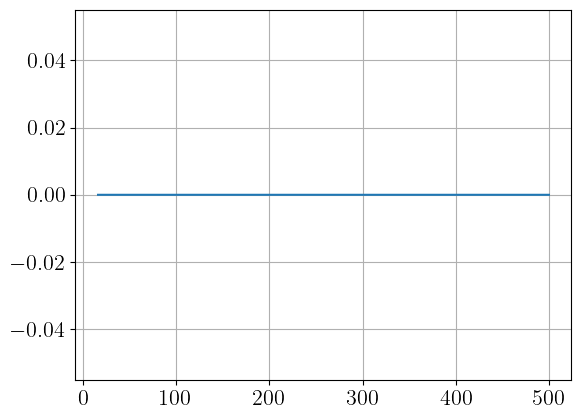

In [317]:
plt.plot(fs_ripple, psi_SS)
plt.show()

### Get tidal amplitude

In [318]:
ampT = np.empty_like(f)
test = lalsim.SimNRTunedTidesFDTidalAmplitudeFrequencySeries(ampT, f, m1, m2, lambda1, lambda2)
test

0

In [319]:
ampT

array([-6.74144216e-03, -6.79971099e-03, -6.85826018e-03, ...,
       -1.91120663e+01, -1.91160716e+01, -1.91200769e+01])

## Computing mismatch

In [320]:
from ripple import get_match_arr

In [321]:
len(hp_ripple)

7743

In [322]:
len(hp_lalsuite)

7743

In [323]:
len(f)

7743

In [324]:
f[-1] % df

0.0

In [325]:
pad_low, pad_high = get_eff_pads(f)
PSD_vals = np.interp(f, f_ASD, ASD) ** 2

match = get_match_arr(
        pad_low,
        pad_high,
        # np.ones_like(fs) * 1.0e-42,
        PSD_vals,
        hp_ripple,
        hp_lalsuite,
    )

print(match)
print(np.log10(1 - match))

0.999999999934116
-10.181220272522408
